In [1]:
import copy
import math
import datetime
import itertools
import requests
from io import BytesIO
from random import randint

import chardet
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.utils.fixes import loguniform
from xgboost import XGBRegressor
from geneticalgorithm import geneticalgorithm

pd.set_option('display.max_columns', None)

In [ ]:
!pip install geneticalgorithm

In [ ]:
import keras

keras.__version__

In [ ]:
filename = './data/genetic4/KRvideos.csv'

with open(filename, 'rb') as f:
    result = chardet.detect(f.readline())
    

In [ ]:
raw_data = pd.read_csv(filename, engine='python')
raw_data.head(5)

In [ ]:
category_id_code = {'1': 'Film & Animation',
                    '2': 'Autos & Vehicles',
                    '10': 'Music',
                    '15': 'Pets & Animals',
                    '17': 'Sports',
                    '18': 'Short Movies',
                    '19': 'Travel & Events',
                    '20': 'Gaming',
                    '21': 'Videoblogging',
                    '22': 'People & Blogs',
                    '23': 'Comedy',
                    '24': 'Entertainment',
                    '25': 'News & Politics',
                    '26': 'Howto & Style',
                    '27': 'Education',
                    '28': 'Science & Technology',
                    '29': 'Nonprofits & Activism',
                    '30': 'Movies',
                    '31': 'Anime/Animation',
                    '32': 'Action/Adventure',
                    '33': 'Classics',
                    '34': 'Comedy',
                    '35': 'Documentary',
                    '36': 'Drama',
                    '37': 'Family',
                    '38': 'Foreign',                    
                    '39': 'Horror',
                    '40': 'Sci-Fi/Fantasy',
                    '41': 'Thriller',
                    '42': 'Shorts',
                    '43': 'Shows',
                    '44': 'Trailers'}

In [ ]:
raw_data.info()

In [ ]:
raw_data['description'].isnull().sum()

In [ ]:
raw_data['ratings_disabled'][raw_data['ratings_disabled']==True].sum()

In [ ]:
raw_data['video_error_or_removed'][raw_data['video_error_or_removed']==True].sum()

In [ ]:
for i  in list(raw_data):
    print(i)
    print(raw_data[i].duplicated().value_counts())
    print('\n')
    

In [ ]:
df = raw_data[raw_data['comments_disabled'] != 1]
df = df[df['ratings_disabled'] != 1]
df = df[df['video_error_or_removed'] != 1]
df = df[df['tags'] !='[none]']
df.head(11)

In [ ]:
print('Before dropna:', len(df))
df = df.dropna()
print('After  dropna:', len(df))
df = df.reset_index(drop=True)

In [ ]:
!pip install requests


In [ ]:
r_avg = []
g_avg = []
b_avg = []
import time

for i in tqdm.tqdm(range(len(df))):    
    url = df['thumbnail_link'][i]
    start = time.time()
    res = requests.get(url)
    request_get_img = Image.open(BytesIO(res.content))
    
    red, green, blue = request_get_img.split()
    
    r_avg.append(int(np.average(red)))
    g_avg.append(int(np.average(green)))
    b_avg.append(int(np.average(blue)))

df['r_avg'] = r_avg
df['g_avg'] = g_avg
df['b_avg'] = b_avg

In [2]:
# 위에거 오래걸려서 해서옴

filename = './data/genetic4/KRvieeos_add_color.csv'

df = pd.read_csv(filename, engine='python')




In [3]:
check_table = df[df['r_avg'] == df['g_avg']]
check_table = check_table[check_table['g_avg'] == check_table['b_avg']]
print('len_check_table', len(check_table))

len_check_table 9682


In [4]:
df_rgb = df[(df['r_avg'] != 193) & (df['b_avg'] != 193) & (df['g_avg'] != 193)]
df_rgb = df_rgb.reset_index(drop=True)
df_rgb.to_csv('df_color_encoded.csv', index_label=False)

In [5]:
print(df['video_id'].duplicated().value_counts())

True     14328
False    11118
Name: video_id, dtype: int64


In [6]:
df_rgb[df_rgb.duplicated('video_id')].sort_values(by='video_id')
print('Before removing duplicated video_id:', len(df_rgb))
df_rgb2 = df_rgb.drop_duplicates('video_id')
print('After  removing duplicated video_id:', len(df_rgb2))
df_rgb2 = df_rgb2.reset_index(drop=True)

Before removing duplicated video_id: 15877
After  removing duplicated video_id: 6680


In [7]:
df_rgb2.head(5)

,Unnamed: 0,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
0,0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22.0,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130.0,1422.0,40.0,272.0,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....,56.0,41.0,31.0
1,2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22.0,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409.0,5112.0,166.0,459.0,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요,105.0,84.0,86.0
2,3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25.0,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850.0,2093.0,173.0,1219.0,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정,89.0,86.0,86.0
3,4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25.0,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466.0,1094.0,109.0,450.0,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...,81.0,77.0,61.0
4,5,AmP0ryzDmbY,17.14.11,김정숙 여사는 왜 갑자기 문재인 대통령 주머니에 손을 넣었나? 인도네시아 대통령도 깜놀,하우스,25.0,2017-11-12T10:17:48.000Z,"김정숙|""김정숙 여사""|""김정숙 문재인""|""문재인 대통령""|""문재인""|""문재인 인도...",188707.0,545.0,311.0,357.0,https://i.ytimg.com/vi/AmP0ryzDmbY/default.jpg,False,False,False,김정숙 여사는 왜 갑자기 문재인 대통령 주머니에 손을 넣었나? 인도네시아 대통령도 ...,117.0,103.0,100.0


In [8]:

df_rgb2 = df_rgb2.dropna()
len(df_rgb2)

6646

In [9]:


df_rgb2['publish_time2'] = df_rgb2['publish_time'].apply(lambda x: x.split('T')[0])
df_rgb2['publish_date'] = df_rgb2['publish_time2'].astype('datetime64[ns]')
df_rgb2['publish_date']

0      2017-11-13
1      2017-11-11
2      2017-11-12
3      2017-11-13
4      2017-11-12
          ...    
6675   2018-06-11
6676   2018-06-13
6677   2018-06-13
6678   2018-06-13
6679   2018-06-13
Name: publish_date, Length: 6646, dtype: datetime64[ns]

In [10]:
df_rgb2['trending_date'] = pd.to_datetime(df_rgb2['trending_date'], format="%y.%d.%m")
df_rgb2['trending_date']

0      2017-11-14
1      2017-11-14
2      2017-11-14
3      2017-11-14
4      2017-11-14
          ...    
6675   2018-06-14
6676   2018-06-14
6677   2018-06-14
6678   2018-06-14
6679   2018-06-14
Name: trending_date, Length: 6646, dtype: datetime64[ns]

In [11]:
df_rgb2['elapsed_day'] = df_rgb2['trending_date'] - df_rgb2['publish_date'] + datetime.timedelta(days=1)
df_rgb2['elapsed_day'] = df_rgb2['elapsed_day'].dt.days
df_rgb2['elapsed_day']

0       2
1       4
2       3
3       2
4       3
       ..
6675    4
6676    2
6677    2
6678    2
6679    2
Name: elapsed_day, Length: 6646, dtype: int64

In [12]:
df_rgb2['total_number_of_sign'] = df_rgb2['likes'] + df_rgb2['dislikes']
df_rgb2['number_of_tag'] = df_rgb2['tags'].apply(lambda x: len(x.split('|')) if x != '[none]' else 0)
df_rgb2['positive_ratio'] = df_rgb2['likes'] /df_rgb2['dislikes']
df_rgb2[df_rgb2['positive_ratio'] == np.inf]
positive_ratio_max = df_rgb2['positive_ratio'].replace([np.inf, -np.inf], 0).max()
df_rgb2['positive_ratio'] = df_rgb2['positive_ratio'].replace([np.inf, -np.inf], positive_ratio_max * 1.5)

df_rgb2['sign_per_day'] = df_rgb2['total_number_of_sign'] / df_rgb2['elapsed_day']
df_rgb2['positive_ratio_per_day'] = df_rgb2['positive_ratio'] / df_rgb2['elapsed_day']
df_rgb2['comment_per_day'] = df_rgb2['comment_count'] / df_rgb2['elapsed_day']
df_rgb2['total_sign_comment_ratio'] = df_rgb2['total_number_of_sign'] / df_rgb2['comment_count']
total_sign_comment_ratio_max = df_rgb2['total_sign_comment_ratio'].replace([np.inf, -np.inf], 0).max()
df_rgb2['total_sign_comment_ratio'] = \
    df_rgb2['total_sign_comment_ratio'].replace([np.inf, -np.inf], total_sign_comment_ratio_max * 1.5)

df_rgb2['description_length'] = df_rgb2['description'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

df_rgb2['title_length'] = df_rgb2['title'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))


In [13]:
df_rgb2['channel_title'].value_counts()

# 채널이 너무 많아서 one hot encoding 하지 않음

TV Derana       103
JTBC News        90
황장수의 뉴스브리핑o      85
tbs 시민의 방송       83
o 황장수의 뉴스브리핑     76
               ... 
하이채드 Hi Chad      1
queensoo          1
chadnisha         1
MBC경남 News        1
한국민속촌 중매쟁이        1
Name: channel_title, Length: 1492, dtype: int64

In [14]:
df_rgb2.groupby('channel_title')['views'].mean()

channel_title
!t Live                   64896.666667
& 홍대 쏭카페창현 거리노래방         150317.500000
(MUTUBE)와꾸대장봉준            72740.000000
* eundaromi              129207.500000
- 欢迎订阅 -浙江卫视【奔跑吧】官方频道    799644.000000
                             ...      
흔한남매                     104829.000000
히스토리                     230128.000000
히죽HIZUK                   77737.000000
히히튜브                      29389.000000
힙합버스                      99130.500000
Name: views, Length: 1492, dtype: float64

In [15]:
mean_encode_channel = df_rgb2.groupby('channel_title')['views'].mean()
# 이렇게 함으로써 각 채널 개개를 view값의 mean으로 categorize할 수 있게 됌

print(mean_encode_channel)

df_rgb2.loc[:, 'channel_title_mean_enc'] = df_rgb2['channel_title'].map(mean_encode_channel)
df_rgb2['channel_title_mean_enc']

channel_title
!t Live                   64896.666667
& 홍대 쏭카페창현 거리노래방         150317.500000
(MUTUBE)와꾸대장봉준            72740.000000
* eundaromi              129207.500000
- 欢迎订阅 -浙江卫视【奔跑吧】官方频道    799644.000000
                             ...      
흔한남매                     104829.000000
히스토리                     230128.000000
히죽HIZUK                   77737.000000
히히튜브                      29389.000000
힙합버스                      99130.500000
Name: views, Length: 1492, dtype: float64


0       125208.000000
1       421409.000000
2       258691.285714
3       184936.645161
4       178386.071429
            ...      
6675     15136.500000
6676     41945.444444
6677     31731.500000
6678     23404.000000
6679    140520.189655
Name: channel_title_mean_enc, Length: 6646, dtype: float64

In [16]:
df_rgb2['category_id'].value_counts()

24.0    1862
25.0    1285
22.0     878
23.0     510
10.0     479
20.0     449
1.0      353
15.0     193
17.0     177
26.0     171
27.0      88
43.0      69
29.0      67
2.0       24
28.0      23
19.0      18
Name: category_id, dtype: int64

In [17]:
mean_encode_category = df_rgb2.groupby('category_id')['views'].mean()
print(mean_encode_category)

df_rgb2.loc[:, 'category_id_mean_enc'] = df_rgb2['category_id'].map(mean_encode_category)
df_rgb2['category_id_mean_enc']

category_id
1.0     3.960160e+05
2.0     8.166904e+04
10.0    1.549140e+06
15.0    1.191287e+05
17.0    7.353312e+05
19.0    2.021387e+05
20.0    1.976639e+05
22.0    1.470981e+05
23.0    2.768867e+05
24.0    4.095744e+05
25.0    1.297828e+05
26.0    3.624022e+05
27.0    9.829427e+04
28.0    1.678646e+06
29.0    2.332710e+04
43.0    7.884158e+04
Name: views, dtype: float64


0       147098.058087
1       147098.058087
2       129782.770428
3       129782.770428
4       129782.770428
            ...      
6675    735331.220339
6676    147098.058087
6677    409574.393663
6678    396016.042493
6679    129782.770428
Name: category_id_mean_enc, Length: 6646, dtype: float64

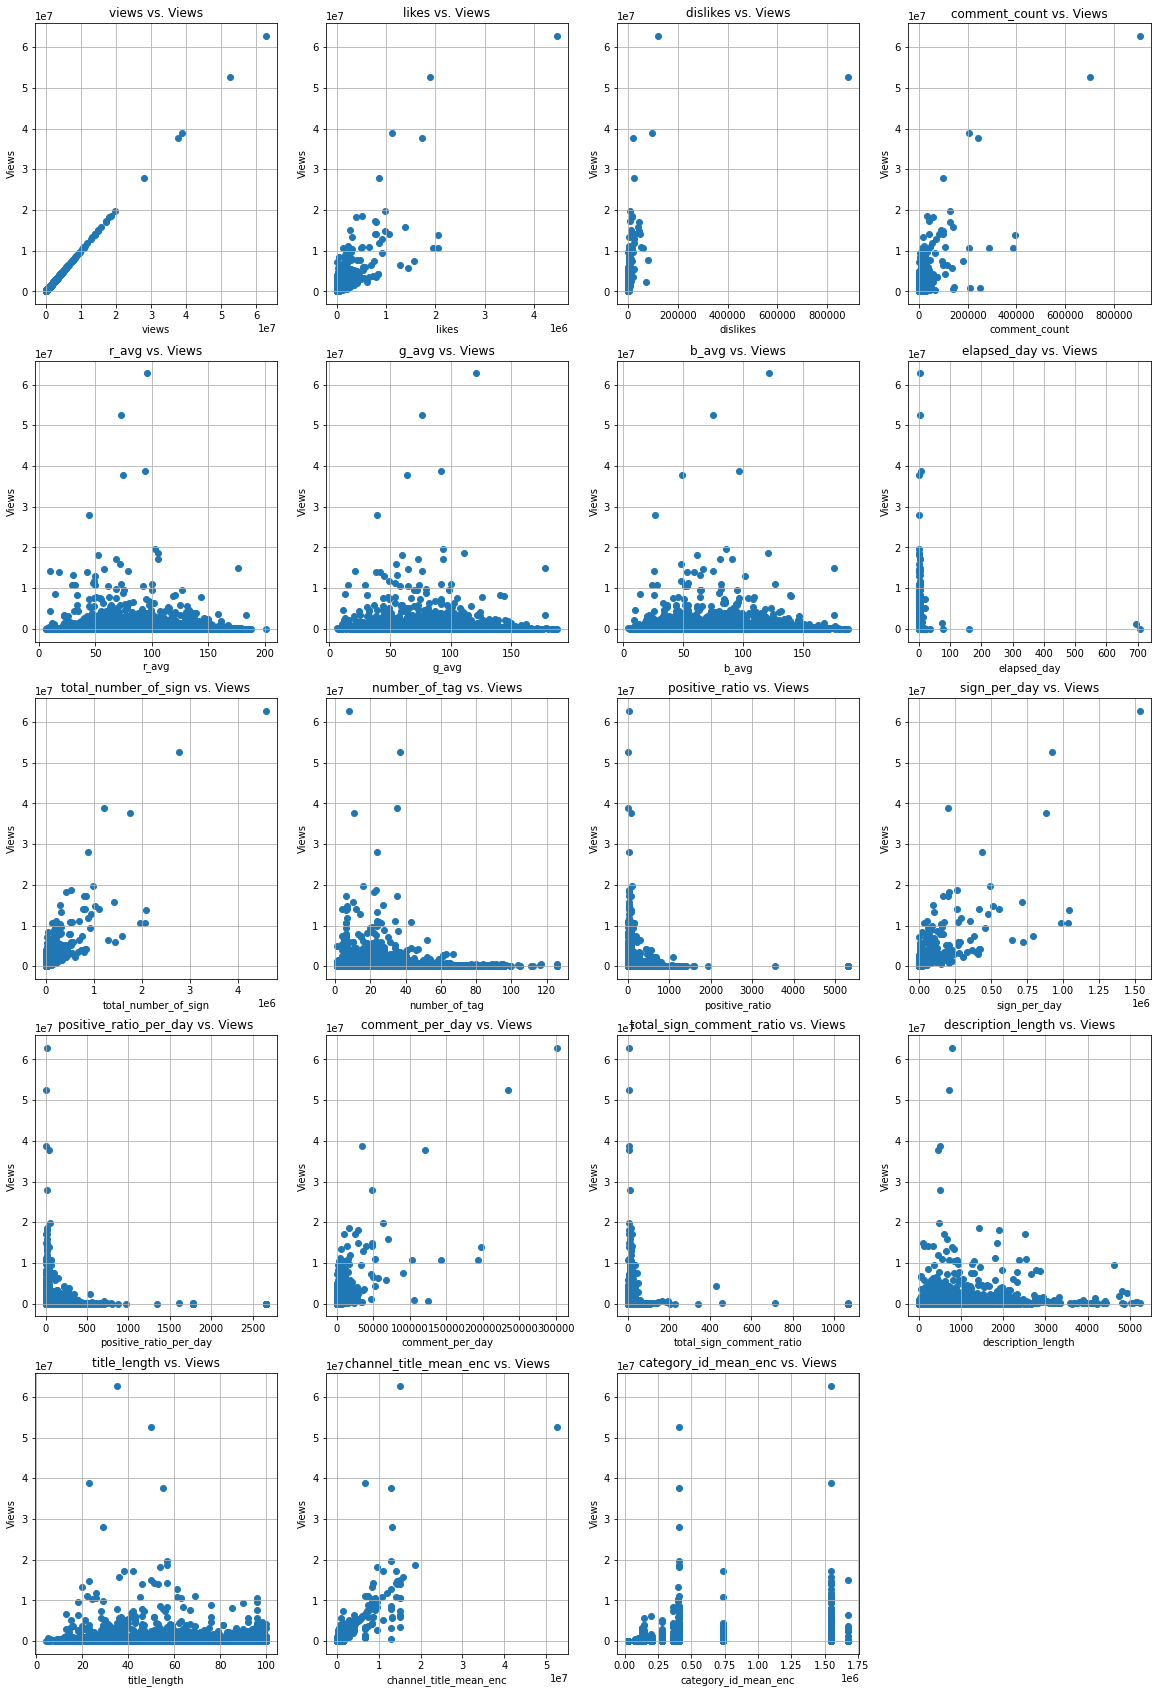

In [18]:
plt.figure(figsize=(20, 30))

for i in range(1, len(df_rgb2.describe().columns)):
    plt.subplot(5, 4, i)
    title = str(df_rgb2.describe().columns[i]) + ' vs. Views'
    plt.title(title)
    plt.xlabel(df_rgb2.describe().columns[i])
    plt.ylabel('Views')
    plt.grid()
    plt.scatter(df_rgb2[df_rgb2.describe().columns[i]], df_rgb2['views'])    

In [19]:
list(df_rgb2)

['Unnamed: 0',
 'video_id',
 'trending_date',
 'title',
 'channel_title',
 'category_id',
 'publish_time',
 'tags',
 'views',
 'likes',
 'dislikes',
 'comment_count',
 'thumbnail_link',
 'comments_disabled',
 'ratings_disabled',
 'video_error_or_removed',
 'description',
 'r_avg',
 'g_avg',
 'b_avg',
 'publish_time2',
 'publish_date',
 'elapsed_day',
 'total_number_of_sign',
 'number_of_tag',
 'positive_ratio',
 'sign_per_day',
 'positive_ratio_per_day',
 'comment_per_day',
 'total_sign_comment_ratio',
 'description_length',
 'title_length',
 'channel_title_mean_enc',
 'category_id_mean_enc']

In [20]:
features = ['likes', 'dislikes', 'comment_count', 'r_avg', 'g_avg', 'b_avg', 'elapsed_day', 'number_of_tag',
            'positive_ratio', 'sign_per_day', 'positive_ratio_per_day', 'comment_per_day',
            'total_sign_comment_ratio', 'description_length', 'title_length', 'channel_title_mean_enc',
            'category_id_mean_enc']

x_input = df_rgb2[features]
cor_table = x_input.corr()
print(cor_table[cor_table > 0.9])

                             likes  dislikes  comment_count  r_avg  g_avg  \
likes                     1.000000       NaN            NaN    NaN    NaN   
dislikes                       NaN       1.0            NaN    NaN    NaN   
comment_count                  NaN       NaN       1.000000    NaN    NaN   
r_avg                          NaN       NaN            NaN    1.0    NaN   
g_avg                          NaN       NaN            NaN    NaN    1.0   
b_avg                          NaN       NaN            NaN    NaN    NaN   
elapsed_day                    NaN       NaN            NaN    NaN    NaN   
number_of_tag                  NaN       NaN            NaN    NaN    NaN   
positive_ratio                 NaN       NaN            NaN    NaN    NaN   
sign_per_day              0.976371       NaN            NaN    NaN    NaN   
positive_ratio_per_day         NaN       NaN            NaN    NaN    NaN   
comment_per_day                NaN       NaN       0.973711    NaN    NaN   

{'icoord': [[5.0, 5.0, 15.0, 15.0], [25.0, 25.0, 35.0, 35.0], [45.0, 45.0, 55.0, 55.0], [30.0, 30.0, 50.0, 50.0], [10.0, 10.0, 40.0, 40.0], [75.0, 75.0, 85.0, 85.0], [65.0, 65.0, 80.0, 80.0], [105.0, 105.0, 115.0, 115.0], [95.0, 95.0, 110.0, 110.0], [155.0, 155.0, 165.0, 165.0], [145.0, 145.0, 160.0, 160.0], [135.0, 135.0, 152.5, 152.5], [125.0, 125.0, 143.75, 143.75], [102.5, 102.5, 134.375, 134.375], [72.5, 72.5, 118.4375, 118.4375], [25.0, 25.0, 95.46875, 95.46875]], 'dcoord': [[0.0, 0.6602072850409412, 0.6602072850409412, 0.0], [0.0, 0.15081901515319737, 0.15081901515319737, 0.0], [0.0, 0.15801083508077934, 0.15801083508077934, 0.0], [0.15081901515319737, 1.040780703499255, 1.040780703499255, 0.15801083508077934], [0.6602072850409412, 1.4897703279060286, 1.4897703279060286, 1.040780703499255], [0.0, 0.2699457911120946, 0.2699457911120946, 0.0], [0.0, 0.4097262418029187, 0.4097262418029187, 0.2699457911120946], [0.0, 0.18741704376904408, 0.18741704376904408, 0.0], [0.0, 1.4504933199

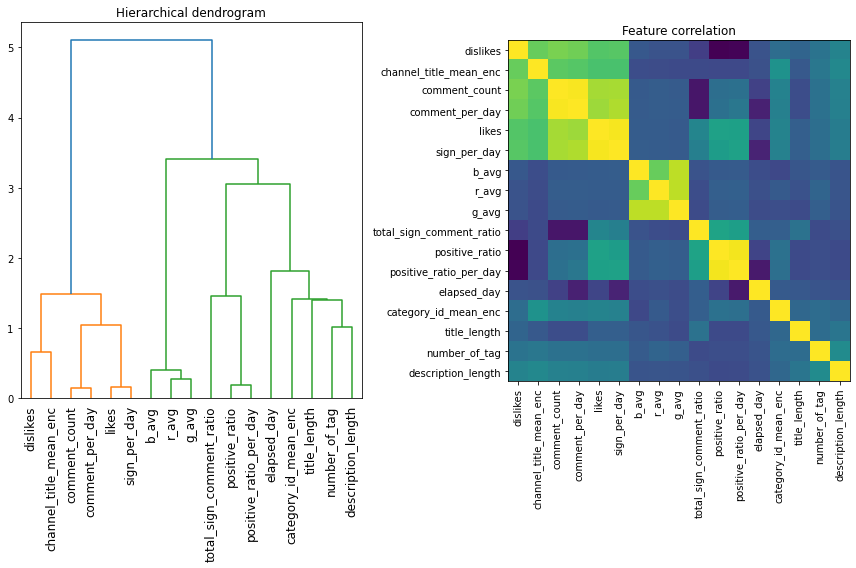

In [23]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation

corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)
print(dendro)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

In [24]:
y_output = df_rgb2['views']

x_train, x_test, y_train, y_test = train_test_split(x_input, y_output, random_state=42)

In [25]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_train_scaled

array([[1.26819508e-04, 2.82497048e-05, 3.91864669e-04, ...,
        3.64583333e-01, 4.63231992e-03, 7.47716594e-02],
       [5.72588959e-05, 4.51995277e-06, 1.49018959e-04, ...,
        6.14583333e-01, 3.23413587e-04, 4.30131042e-01],
       [2.16062865e-04, 3.61596221e-05, 2.31807269e-04, ...,
        2.08333333e-01, 3.09887412e-03, 9.21763906e-01],
       ...,
       [1.85107274e-03, 2.97186894e-04, 4.47608798e-03, ...,
        1.04166667e-01, 5.91705961e-03, 1.05319177e-01],
       [3.61223113e-04, 3.45776387e-04, 7.57237078e-04, ...,
        1.77083333e-01, 2.65521899e-03, 4.30131042e-01],
       [7.24906568e-04, 6.89292797e-05, 4.32706902e-04, ...,
        3.54166667e-01, 6.18078504e-04, 6.43112666e-02]])

In [26]:
model_name = []
train_perf = []
test_perf = []

Fitting 5 folds for each of 1900 candidates, totalling 9500 fits
Best_estimator: ElasticNet(alpha=0.0026000000000000007, l1_ratio=0.9900000000000001,
           max_iter=100000000, random_state=42, tol=0.0316)
Best_params: {'alpha': 0.0026000000000000007, 'l1_ratio': 0.9900000000000001, 'tol': 0.0316}
Best_score: 0.7591023976996338
Train score: 0.8241548311849243
Test  score: 0.6678838024778282


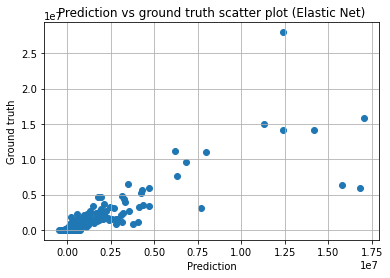

In [27]:
en_model = ElasticNet(max_iter=100000000, random_state=42)
# 보합되지 않을 경우 max_iter이 의미가 있을 수 있음

#l1 l2규제를 얼마의 비율로 쓸것인지 0.9면 90퍼센트의 l1 ratio
# tol 임계값을 얼마 이하값으로 
# alpha는 가중치
en_param = {'l1_ratio': np.arange(0.9, 0.995, 0.005),
            'alpha': np.arange(0.0008, 0.0028, 0.0001),
            'tol': [1e-2, 3.16e-2, 1e-1, 3.16e-1, 1e0]}

clf = GridSearchCV(estimator=en_model, param_grid=en_param, n_jobs=-1, verbose=3)
# GridSearch를 하고 Cross validation
# 코어를  몇개 쓸건지 -1은 모든 코어를 다쓰겠다

clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Elastic Net')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Elastic Net)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [28]:
en_model = ElasticNet(alpha=0.0027, l1_ratio=0.96, tol=0.1, max_iter=100000000, random_state=42)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best_estimator: RandomForestRegressor(max_depth=30, n_estimators=76, n_jobs=-1, random_state=42)
Best_params: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 76}
Best_score: 0.7936340085454179
Train score: 0.9666157083858711
Test  score: 0.8281722682041546


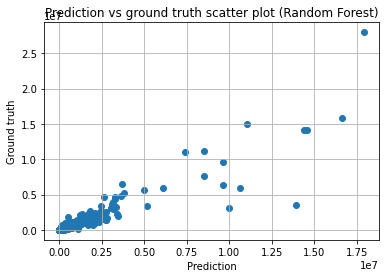

In [29]:
rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)

rf_param = {'n_estimators': range(76, 136, 20),
            'max_depth': range(30, 42, 4),
            'min_samples_split': range(2, 5, 1)}

clf = GridSearchCV(estimator=rf_model, param_grid=rf_param, n_jobs=-1, verbose=2)

clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Random Forest')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Random Forest)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [30]:
#위에서 찾아진 값들을 직접 입력

rf_model = RandomForestRegressor(n_estimators=76, max_depth=30, min_samples_split=2, n_jobs=-1, random_state=42)

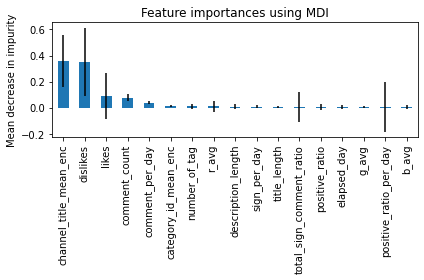

In [31]:
rf_model.fit(x_train_scaled, y_train)

feature_names = ['feature {i}' for i in range(x_train_scaled.shape[1])]

importances = rf_model.feature_importances_
# estimators_에는 각 Tree의 estimatior들의 정보가 들어있고, 해당 tree의 feature_importances_를 받아서 std태움
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

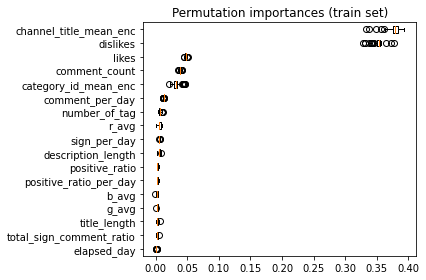

In [32]:
result = permutation_importance(rf_model, x_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
#박스가 median 상위 50% 점과 하위 50%점 두개가 나윔
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best_estimator: MLPRegressor(alpha=0.0005105903209394755, early_stopping=True,
             hidden_layer_sizes=(27, 26, 26, 29), learning_rate='adaptive',
             max_iter=2000000, random_state=42, verbose=0)
Best_params: {'alpha': 0.0005105903209394755, 'hidden_layer_sizes': (27, 26, 26, 29)}
Best_score: 0.6843850250924475
Train score: 0.6964845128972456
Test  score: 0.6120314179747711


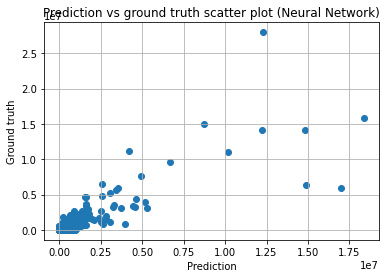

In [33]:
# adaptive 오차율의 변화에 따라 맞추는데, 초중반에는 러닝레이트 크게가다가 나중가면 줄어듦
# verbose 로그출력의 기준 숫자가 클수록 많은 log 출력
mlp_model = MLPRegressor(learning_rate='adaptive', max_iter=2000000, verbose=0,
                         early_stopping=True, random_state=42)

mlp_param = {'hidden_layer_sizes': [x for x in itertools.product((range(24, 32)), repeat=4)],
             'alpha': loguniform(1e-4, 1e-3)}

rand_clf = RandomizedSearchCV(estimator=mlp_model, param_distributions=mlp_param, n_iter=10, n_jobs=-1,
                              cv=3, verbose=2, random_state=42)

rand_clf.fit(x_train_scaled, y_train)

y_train_pred = rand_clf.predict(x_train_scaled)
y_test_pred = rand_clf.predict(x_test_scaled)

print('Best_estimator:', rand_clf.best_estimator_)
print('Best_params:', rand_clf.best_params_)
print('Best_score:', rand_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Neural Network')
train_perf.append(train_score)
test_perf.append(test_score)
plt.title('Prediction vs ground truth scatter plot (Neural Network)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [34]:
mlp_model = MLPRegressor(hidden_layer_sizes=(27, 26, 26, 29), alpha=0.0005105903209394755, learning_rate='adaptive',
                         max_iter=2000000, verbose=0, early_stopping=True, random_state=42)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best_estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=120, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Best_params: {'max_depth': 2, 'n_estimators': 120, 'reg_alpha': 0.1, 'reg_lambda': 1}
Best_score: 0.8524150060969123
Train score: 0.9915677285588075
Test  score: 0.7858206237064476


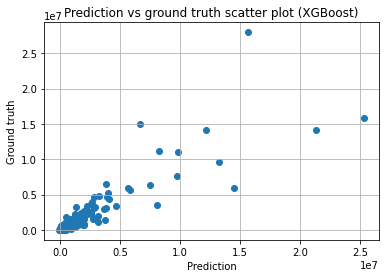

In [35]:
xgb_model = XGBRegressor(n_jobs=-1, random_state=42)

xgb_param = {'n_estimators': range(80, 140, 20),
             'max_depth': range(2, 5, 1),
             'reg_alpha': [1e-2, 3.16e-2, 1e-1],
             'reg_lambda': [0.1, 0.316, 1]}

xgb_clf = GridSearchCV(estimator=xgb_model, param_grid=xgb_param, n_jobs=-1, verbose=2, cv=3)

xgb_clf.fit(x_train_scaled, y_train)
y_train_pred = xgb_clf.predict(x_train_scaled)
y_test_pred = xgb_clf.predict(x_test_scaled)

print('Best_estimator:', xgb_clf.best_estimator_)
print('Best_params:', xgb_clf.best_params_)
print('Best_score:', xgb_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('XGBoost')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (XGBoost)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [36]:
xgb_model = XGBRegressor(max_depth=4, n_estimators=120, reg_alpha=0.1, reg_lambda=0.1, n_jobs=-1, random_state=42)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best_estimator: SVR(C=100000000.0, gamma=0.1)
Best_params: {'C': 100000000.0, 'gamma': 0.1}
Best_score: 0.7094402559859873
Train score: 0.694098709886912
Test  score: 0.733900608196342


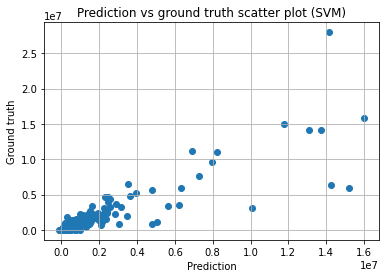

In [37]:
svr_model = SVR()

svr_param = {'C': [3.16e7, 1e8],
             'gamma': [0.1, 0.316]}

svr_clf = GridSearchCV(estimator=svr_model, param_grid=svr_param, n_jobs=-1, verbose=3, cv=3)

svr_clf.fit(x_train_scaled, y_train)
y_train_pred = svr_clf.predict(x_train_scaled)
y_test_pred = svr_clf.predict(x_test_scaled)

print('Best_estimator:', svr_clf.best_estimator_)
print('Best_params:', svr_clf.best_params_)
print('Best_score:', svr_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('SVM')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (SVM)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [39]:
svr_model = SVR(C=1e8, gamma=0.1)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best_estimator: KNeighborsRegressor(leaf_size=1, n_jobs=-1, n_neighbors=4, weights='distance')
Best_params: {'leaf_size': 1, 'n_neighbors': 4, 'weights': 'distance'}
Best_score: 0.5221640411271019
Train score: 1.0
Test  score: 0.02141778057498933


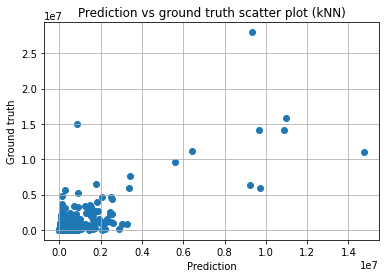

In [40]:
knn_model = KNeighborsRegressor(n_jobs=-1)

knn_param = {'n_neighbors': range(1, 6, 1),
             'weights': ['uniform', 'distance'],
             'leaf_size': range(1, 5, 1)}

knn_clf = GridSearchCV(estimator=knn_model, param_grid=knn_param, n_jobs=-1, verbose=3)

knn_clf.fit(x_train_scaled, y_train)
y_train_pred = knn_clf.predict(x_train_scaled)
y_test_pred = knn_clf.predict(x_test_scaled)

print('Best_estimator:', knn_clf.best_estimator_)
print('Best_params:', knn_clf.best_params_)
print('Best_score:', knn_clf.best_score_)
print('Train score:', r2_score(y_train_pred, y_train))
print('Test  score:', r2_score(y_test_pred, y_test))

plt.title('Prediction vs ground truth scatter plot (kNN)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

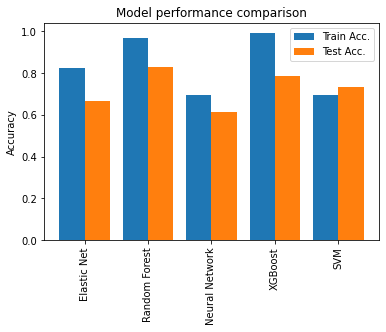

In [41]:
plt.title('Model performance comparison')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')

x = np.arange(len(model_name))
plt.xticks(x, model_name)
plt.bar(x - 0.2, train_perf, width=0.4, label='Train Acc.')
plt.bar(x + 0.2, test_perf, width=0.4, label='Test Acc.')
plt.legend()

1 Ensemble train score: 0.9992254461958331
1 Ensemble test  score: 0.8411513072135952
2 Ensemble train score: 0.99182168223634
2 Ensemble test  score: 0.8482734956364444
3 Ensemble train score: 0.9488750115246973
3 Ensemble test  score: 0.8277202070717486
4 Ensemble train score: 0.9146191326470943
4 Ensemble test  score: 0.7983742399436822
5 Ensemble train score: 0.8896888962974593
5 Ensemble test  score: 0.7748712743035068


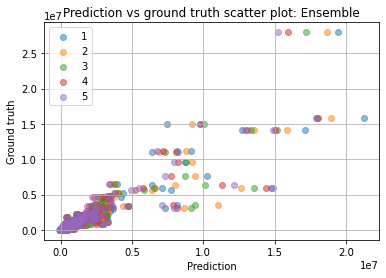

In [42]:
ensemble_list = [('xgb', xgb_model),
                 ('rf', rf_model),
                 ('svm', svr_model),
                 ('mlp', mlp_model),
                 ('en', en_model)]

voting_est = []

for idx, target_model in enumerate(ensemble_list):
    voting_est.append(target_model)

    voting_clf = VotingRegressor(estimators=voting_est, n_jobs=-1)
    voting_clf.fit(x_train_scaled, y_train)
    y_train_pred = voting_clf.predict(x_train_scaled)
    y_test_pred = voting_clf.predict(x_test_scaled)
    print(idx + 1, 'Ensemble train score:', r2_score(y_train_pred, y_train))
    print(idx + 1, 'Ensemble test  score:', r2_score(y_test_pred, y_test))

    plt.scatter(y_test_pred, y_test, label=str(idx + 1), alpha=0.5)
    title = 'Prediction vs ground truth scatter plot: Ensemble'     
    plt.title(title)
    plt.xlabel('Prediction')
    plt.ylabel('Ground truth')
    plt.grid()
    plt.legend()

In [43]:
voting_clf = VotingRegressor(estimators=[('xgb', xgb_model), ('rf', rf_model), ('svm', svr_model)],
                             n_jobs=-1)
voting_clf.fit(x_train_scaled, y_train)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=4,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=120, n_jobs=-1,
                                          num_parallel_tree=None,
                                          random_state=42, reg_alpha=0.1,
                                    

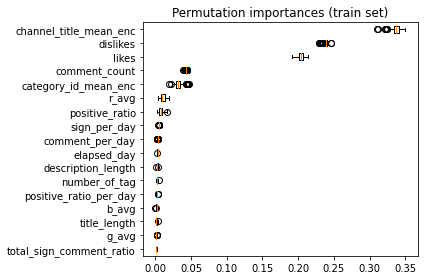

In [44]:
result = permutation_importance(voting_clf, x_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

In [61]:
# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'

features = ['likes', 'dislikes', 'comment_count', 'elapsed_day', 'number_of_tag', 'positive_ratio', 'description_length', 'title_length',
            'r_avg', 'g_avg', 'b_avg', 'channel_title_mean_enc','category_id_mean_enc']

x_input = df_rgb2[features]
print(x_input)

varbound = np.array([[df_rgb2['likes'].min(), df_rgb2['likes'].max()*2],
                     [df_rgb2['dislikes'].min() + 1, df_rgb2['dislikes'].max()*2],
                     [df_rgb2['comment_count'].min() + 1, df_rgb2['comment_count'].max()*2],
                     [df_rgb2['elapsed_day'].min(), df_rgb2['elapsed_day'].max()],
                     [df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max()],
                     [df_rgb2['description_length'].min(), df_rgb2['description_length'].max()],
                     [df_rgb2['title_length'].min(), df_rgb2['title_length'].max()*2],
                     [df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max()],
                     [df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max()],
                     [df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max()],
                     [0, len(mean_encode_channel) - 1],
                     # [0, len(mean_encode_category) - 1]],
                     [2, 2]])

       likes  dislikes  comment_count  elapsed_day  number_of_tag  \
0     1422.0      40.0          272.0            2              6   
1     5112.0     166.0          459.0            4              6   
2     2093.0     173.0         1219.0            3              9   
3     1094.0     109.0          450.0            2              7   
4      545.0     311.0          357.0            3              6   
...      ...       ...            ...          ...            ...   
6675    17.0       1.0            7.0            4             23   
6676  1697.0      15.0          296.0            2              9   
6677   205.0      10.0           59.0            2             40   
6678   190.0      29.0          111.0            2             25   
6679    86.0      11.0           18.0            2             10   

      positive_ratio  description_length  title_length  r_avg  g_avg  b_avg  \
0          35.550000                 152            18   56.0   41.0   31.0   
1          30

In [57]:
def input_conversion(x_input):
    conversion = [int(x_input[0]),
                  int(x_input[1]),
                  int(x_input[2]),
                  int(x_input[3]),
                  int(x_input[4]),
                  x_input[0] / x_input[1],
                  int(x_input[5]),
                  int(x_input[6]),
                  int(x_input[7]),
                  int(x_input[8]),
                  int(x_input[9]),
                  mean_encode_channel.iloc[int(x_input[10])],
                  mean_encode_category.iloc[int(x_input[11])]]

    return conversion

In [58]:
def object_function_median(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled)        

    target = df_rgb2['views'].median()
    print('Predicted views:', int(prediction), 'Difference from target:', int(prediction - target))

    # return abs(int(prediction) - target)
    return math.log(abs(target - int(prediction))) 

In [59]:
algorithm_param = {'max_num_iteration': 300,
                   'population_size': 100,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

In [62]:
model_ga_median = geneticalgorithm(function=object_function_median,
                                   dimension=12,
                                   variable_type='int',
                                   variable_boundaries=varbound,
                                   algorithm_parameters=algorithm_param)

model_ga_median.run()

ValueError: X has 13 features, but MinMaxScaler is expecting 17 features as input.

In [46]:
def object_function_top(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled)        

    target = 70000000
    print('Predicted views:', int(prediction), 'Difference from target:', int(target - prediction))

    # return abs(int(prediction) - target)
    return math.log(abs(target - int(prediction))) 

In [47]:
algorithm_param = {'max_num_iteration': 300,
                   'population_size': 100,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

In [50]:
model_ga_top = geneticalgorithm(function=object_function_top,
                                dimension=12,
                                variable_type='int',
                                variable_boundaries=varbound,
                                algorithm_parameters=algorithm_param)

model_ga_top.run()

ValueError: X has 13 features, but MinMaxScaler is expecting 17 features as input.